In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Unfortunatley, YFinance does not provide the recommendations for all publicly traded companies.
### However, tech stocks and other large cap companies often work

In [46]:
#Change this variable to the ticker you are interested in analyzing (FAANG stocks work well and so do other large cap corps)
symbol = "NVDA"
ticker = yf.Ticker(symbol)

In [47]:
#Look at all reco types before we format them
df_base = ticker.recommendations.reset_index()
df = df_base.copy()
df['To Grade'].value_counts()

Buy                  115
Outperform            45
Hold                  31
Overweight            28
Neutral               21
Equal-Weight          17
Market Perform        12
Underperform           9
Underweight            8
Positive               6
Reduce                 4
Sell                   2
Strong Buy             1
Sector Perform         1
Sector Weight          1
Market Outperform      1
Negative               1
Perform                1
Equal-weight           1
Name: To Grade, dtype: int64

In [48]:
import datetime as dt
df['Date'] = df['Date'].dt.floor('D') # Remove seconds

In [49]:
df['To Grade'] = np.where((df['To Grade'].isin(['Outperform','Overweight','Positive','Market Outperform','Strong Buy'])),(
'Buy'),df['To Grade']) #Changing terms to Buy

In [50]:
df['To Grade'] = np.where((df['To Grade'].isin(['Neutral','Market Perform','Equal-Weight', 'Sector Perform','Perform','Equal-weight',
                                               'In-Line','Peer Perform','Sector Weight'])),
                          'Hold',df['To Grade']) #Changing terms to Hold

In [51]:
df['To Grade'] = np.where((df['To Grade'].isin(['Underperform','Underweight','Reduce','Negative'])),
'Sell',df['To Grade']) #Changing terms to Sell

In [52]:
df['To Grade'].value_counts()
#Check to make sure there aren't any significant reco types that we forgot to convert

Buy     196
Hold     85
Sell     24
Name: To Grade, dtype: int64

In [53]:
#Remove any values that are not buy/sell/hold
df = df.loc[(df['To Grade'] == 'Hold')|(df['To Grade']=='Buy')|(df['To Grade']=='Sell')].copy()

In [54]:
prices = yf.download(symbol,interval = '1d', progress=False)

### Create dfs for upcoming line/scatter plot

In [55]:
df_buy = df.loc[df['To Grade']=='Buy']
df_sell = df.loc[df['To Grade']=='Sell']

In [56]:
#get buy and sell in prices df so we can scatter plot them on the price plot
plot_buy = prices.merge(df_buy,on='Date', how = 'left')
plot_sell = prices.merge(df_sell,on='Date', how = 'left')

In [57]:
plot_buy = plot_buy.loc[plot_buy['To Grade']=='Buy']
plot_sell = plot_sell.loc[plot_sell['To Grade']=='Sell']

In [58]:
prices = prices.reset_index()

In [59]:
df1 = prices.merge(df, on='Date',how='left')
df1.drop(columns = ['Open','High','Low','Close','Volume','From Grade'],inplace= True)

### Calculating percent return after different time periods

In [60]:
dt_adj = 261/365 #use to adjust our desired windows as US has 261 working days a year
time_periods = [30,60,180,360,360*2,360*3,360*5]

for period in time_periods:
    df1['{} day return'.format(period)] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*period))


In [61]:
#Shifting the df columns back so that the future return is on the day the reco was made

for period in time_periods:
    df1['{} day return'.format(period)] = df1['{} day return'.format(period)].shift(-int(dt_adj*30))

df1.rename(columns = {'720 day return':'2 year return',\
                     '1080 day return':'3 year return',\
                     '1800 day return':'5 year return'}, inplace = True)

In [62]:
df1

,Date,Adj Close,Firm,To Grade,Action,30 day return,60 day return,180 day return,360 day return,2 year return,3 year return,5 year return
0,1999-01-22,1.508857,NaN,NaN,NaN,0.117460,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-25,1.666928,NaN,NaN,NaN,0.091954,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-26,1.537597,NaN,NaN,NaN,0.146418,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-27,1.532807,NaN,NaN,NaN,0.096875,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-28,1.528017,NaN,NaN,NaN,0.106583,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5595,2020-10-06,549.460022,BMO Capital,Buy,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5596,2020-10-06,549.460022,JP Morgan,Buy,main,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5597,2020-10-07,558.559998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5598,2020-10-08,553.549988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
#Need to format df so that it can be used in a boxplot
return_gp = df1.groupby(['To Grade','Firm']).mean().reset_index()
return_gp.drop(columns = 'Adj Close',inplace=True)

return_melt = return_gp.melt(id_vars=['To Grade','Firm'])
return_melt_short = return_melt.loc[(return_melt['variable']=='30 day return')|
                                    (return_melt['variable']=='90 day return')|
                                    (return_melt['variable']=='180 day return')|
                                    (return_melt['variable']=='360 day return')]

return_melt_long = return_melt.loc[(return_melt['variable']=='2 year return')|
                                    (return_melt['variable']=='3 year return')|
                                   (return_melt['variable']=='5 year return')|
                                    (return_melt['variable']=='360 day return')]

### Uncomment and change the datemin and datemax variables to zoom in on certain dates

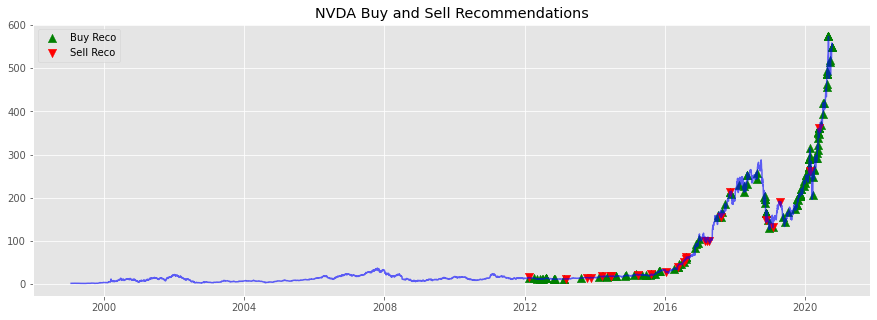

In [64]:
fig = plt.figure(figsize = (15,5))
plt.style.use('ggplot')

#variables for plot to make tweaking easier
line_alpha = 0.6
marker_alpha = 1
line_color = 'b'
buy_color = 'g'
sell_color = 'r'
marker_s = 70

ax = plt.subplot(1,1,1)
plt.plot(prices.Date, prices['Adj Close'], color =line_color, alpha=line_alpha)
plt.scatter(x = plot_buy.Date, y = plot_buy['Adj Close'], color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
plt.scatter(x = plot_sell.Date, y = plot_sell['Adj Close'], color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
plt.title('{} Buy and Sell Recommendations'.format(symbol))
plt.legend(loc=2)

plt.show()
#datemin = dt.date(2018, 7, 1)
#datemax = dt.date(2020, 7, 24)
#ax.set_xlim(datemin, datemax)

<ipython-input-65-7f1ff58b7bec>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])


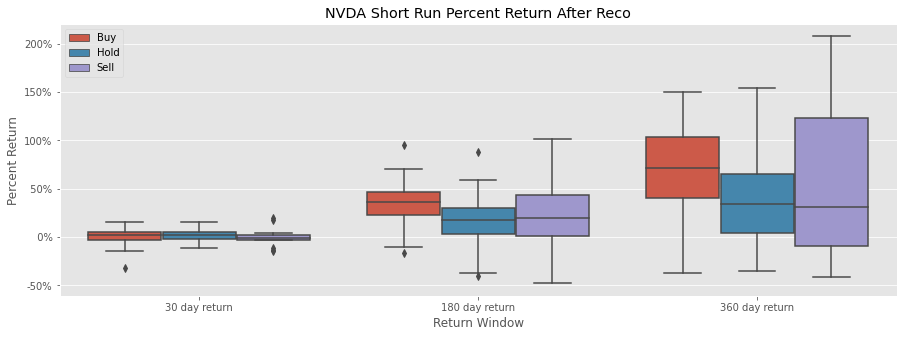

In [65]:
plt.figure(figsize = (15,5))


ax = sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_short)
plt.title('{} Short Run Percent Return After Reco'.format(symbol))
plt.ylabel('Percent Return')
plt.xlabel('Return Window')
plt.legend(loc = 2)

#Format y ticks to percentage
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

plt.show()

<ipython-input-66-7db5ac7e3c9e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])


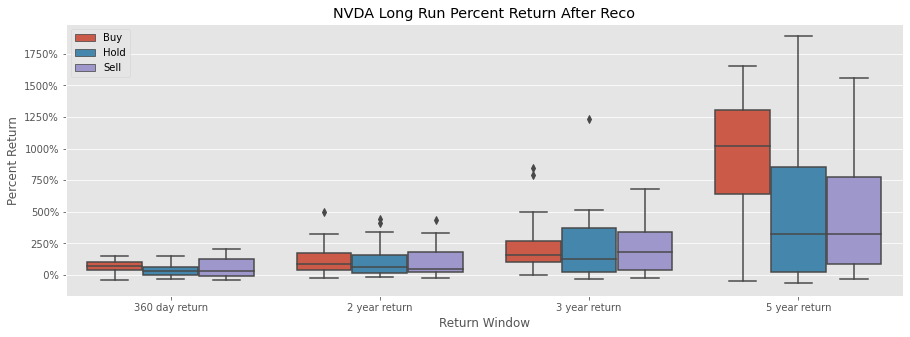

In [66]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_long)
plt.title('{} Long Run Percent Return After Reco'.format(symbol))
plt.ylabel('Percent Return')
plt.xlabel('Return Window')
plt.legend(loc = 2)

#Format y ticks to percentage
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

plt.show()